In [207]:
import os
import cv2
import time
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import RandomSampler

import torchvision.transforms as T
import torchvision.models as models
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder

from matplotlib import pyplot as plt

DIR_TRAIN = "./data/train/"
DIR_VALID = "./data/valid/"
DIR_TEST = "./data/test/"

In [208]:
### Exploring Dataset

classes = os.listdir(DIR_TRAIN)
print("Total Classes: ",len(classes))

#Counting total train, valid & test images

train_count = 0
valid_count = 0
test_count = 0
for _class in classes:
    train_count += len(os.listdir(DIR_TRAIN + _class))
    valid_count += len(os.listdir(DIR_VALID + _class))
    test_count += len(os.listdir(DIR_TEST + _class))

print("Total train images: ",train_count)
print("Total valid images: ",valid_count)
print("Total test images: ",test_count)

Total Classes:  450
Total train images:  70626
Total valid images:  2250
Total test images:  2250


(224, 224, 3)

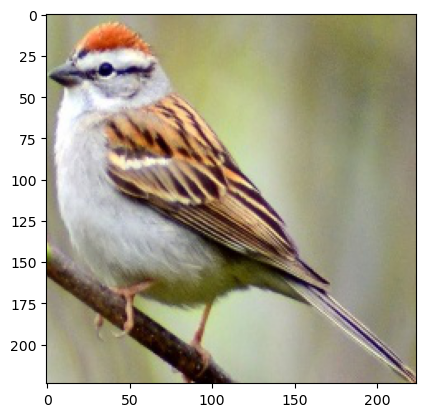

In [209]:
from matplotlib import pyplot as plt
from matplotlib import image as img

im = img.imread(f"{DIR_TRAIN}{_class}/{os.listdir(f'{DIR_TRAIN}{_class}')[0]}")
plt.imshow(im)
im.shape

In [210]:
train_imgs = []
valid_imgs = []
test_imgs = []

for _class in classes:
    
    for img in os.listdir(DIR_TRAIN + _class):
        train_imgs.append(DIR_TRAIN + _class + "/" + img)
    
    for img in os.listdir(DIR_VALID + _class):
        valid_imgs.append(DIR_VALID + _class + "/" + img)
        
    for img in os.listdir(DIR_TEST + _class):
        test_imgs.append(DIR_TEST + _class + "/" + img)

class_to_int = {classes[i] : i for i in range(len(classes))}

In [211]:
def get_transform():
    return T.Compose([
        T.ToTensor(),
        T.Resize((224,224))
    ])

class BirdDataset(Dataset):
    
    def __init__(self, imgs_list, class_to_int, transforms=T.Compose([])):
        super().__init__()
        self.imgs_list = imgs_list
        self.class_to_int = class_to_int
        self.transforms = transforms
        
    def __getitem__(self, index):
        image_path = self.imgs_list[index]
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        label = image_path.split("/")[-2]
        label = self.class_to_int[label]
        
        if self.transforms:
            image = self.transforms(image)
            
        return image, label
    
    def __len__(self):
        return len(self.imgs_list)

In [212]:
train_dataset = BirdDataset(train_imgs, class_to_int, transforms=get_transform())
valid_dataset = BirdDataset(valid_imgs, class_to_int, transforms=get_transform())
test_dataset = BirdDataset(test_imgs, class_to_int, transforms=get_transform())

print(len(train_imgs))
# train_dataset = ImageFolder(root = DIR_TRAIN, transform = T.ToTensor())
# valid_dataset = ImageFolder(root = DIR_VALID, transform = T.ToTensor())
# test_dataset = ImageFolder(root = DIR_TEST, transform = T.ToTensor())

train_random_sampler = RandomSampler(train_dataset)
valid_random_sampler = RandomSampler(valid_dataset)
test_random_sampler = RandomSampler(test_dataset)

train_data_loader = DataLoader(
    dataset=train_dataset,
    batch_size=64,
    sampler=train_random_sampler,
    
)

valid_data_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=64,
    sampler=valid_random_sampler,
)

test_data_loader = DataLoader(
    dataset=test_dataset,
    batch_size=64,
    sampler=test_random_sampler,
)


70626


In [213]:
### Define model
model = models.vgg16(pretrained = True)

### Modifying last few layers and no of classes
# NOTE: cross_entropy loss takes unnormalized op (logits), then function itself applies softmax and calculates loss, so no need to include softmax here
model.classifier = nn.Sequential(
    nn.Linear(25088, 4096, bias = True),
    nn.ReLU(inplace = True),
    nn.Dropout(0.4),
    nn.Linear(4096, 2048, bias = True),
    nn.ReLU(inplace = True),
    nn.Dropout(0.4),
    nn.Linear(2048, 450)
)

In [214]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()

model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=.75)
criterion = nn.CrossEntropyLoss()

train_loss = []
train_accuracy = []

val_loss = []
val_accuracy = []

epochs = 20

In [215]:
def calc_accuracy(true,pred):
    pred = F.softmax(pred, dim = 1)
    true = torch.zeros(pred.shape[0], pred.shape[1]).scatter_(1, true.unsqueeze(1), 1.)
    acc = (true.argmax(-1) == pred.argmax(-1)).float().detach().numpy()
    acc = float((100 * acc.sum()) / len(acc))
    return round(acc, 4)

In [216]:
### Training Code
from tqdm import tqdm

for epoch in range(epochs):
    
    start = time.time()
    
    #Epoch Loss & Accuracy
    train_epoch_loss = []
    train_epoch_accuracy = []
    _iter = 1
    
    #Val Loss & Accuracy
    val_epoch_loss = []
    val_epoch_accuracy = []
    
    # Training
    for images, labels in tqdm(train_data_loader):
        
        images = images.to(device)
        labels = labels.to(device)
        
        #Reset Grads
        optimizer.zero_grad()
        
        #Forward ->
        preds = model(images)
        
        #Calculate Accuracy
        acc = calc_accuracy(labels.cpu(), preds.cpu())
        
        #Calculate Loss & Backward, Update Weights (Step)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        
        #Append loss & acc
        loss_value = loss.item()
        train_epoch_loss.append(loss_value)
        train_epoch_accuracy.append(acc)
        
        _iter += 1
    
    #Validation
    for images, labels in tqdm(valid_data_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        #Forward ->
        preds = model(images)
        
        #Calculate Accuracy
        acc = calc_accuracy(labels.cpu(), preds.cpu())
        
        #Calculate Loss
        loss = criterion(preds, labels)
        
        #Append loss & acc
        loss_value = loss.item()
        val_epoch_loss.append(loss_value)
        val_epoch_accuracy.append(acc)
    
    
    train_epoch_loss = np.mean(train_epoch_loss)
    train_epoch_accuracy = np.mean(train_epoch_accuracy)
    
    val_epoch_loss = np.mean(val_epoch_loss)
    val_epoch_accuracy = np.mean(val_epoch_accuracy)
    
    end = time.time()
    
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
    
    #Print Epoch Statistics
    pytorch

100%|███████████████████████████████████████████| 36/36 [00:04<00:00,  7.88it/s]


** Epoch 0 ** - Epoch Time 345
Train Loss = 2.5231
Train Accuracy = 47.91691639492753 % 

Val Loss = 0.6584
Val Accuracy = 82.63020833333333 % 



100%|███████████████████████████████████████████| 36/36 [00:04<00:00,  7.85it/s]


** Epoch 1 ** - Epoch Time 349
Train Loss = 0.6072
Train Accuracy = 84.01068306159421 % 

Val Loss = 0.466
Val Accuracy = 87.28298611111111 % 



100%|███████████████████████████████████████████| 36/36 [00:04<00:00,  7.85it/s]


** Epoch 2 ** - Epoch Time 347
Train Loss = 0.3182
Train Accuracy = 91.11128315217391 % 

Val Loss = 0.3652
Val Accuracy = 90.59027777777777 % 



100%|███████████████████████████████████████████| 36/36 [00:04<00:00,  7.96it/s]


** Epoch 3 ** - Epoch Time 345
Train Loss = 0.2107
Train Accuracy = 93.87787726449275 % 

Val Loss = 0.3835
Val Accuracy = 90.14756944444444 % 



100%|███████████████████████████████████████████| 36/36 [00:04<00:00,  7.98it/s]


** Epoch 4 ** - Epoch Time 345
Train Loss = 0.1548
Train Accuracy = 95.52263161231885 % 

Val Loss = 0.3602
Val Accuracy = 90.98090277777777 % 



100%|███████████████████████████████████████████| 36/36 [00:04<00:00,  7.94it/s]


** Epoch 5 ** - Epoch Time 345
Train Loss = 0.1348
Train Accuracy = 96.05870027173913 % 

Val Loss = 0.349
Val Accuracy = 90.52083333333333 % 



100%|███████████████████████████████████████████| 36/36 [00:04<00:00,  7.95it/s]


** Epoch 6 ** - Epoch Time 345
Train Loss = 0.1083
Train Accuracy = 96.95159311594203 % 

Val Loss = 0.3383
Val Accuracy = 91.54513888888889 % 



100%|███████████████████████████████████████████| 36/36 [00:04<00:00,  7.91it/s]


** Epoch 7 ** - Epoch Time 345
Train Loss = 0.0996
Train Accuracy = 97.06889719202898 % 

Val Loss = 0.3975
Val Accuracy = 90.73784722222223 % 



100%|███████████████████████████████████████████| 36/36 [00:04<00:00,  7.98it/s]


** Epoch 8 ** - Epoch Time 346
Train Loss = 0.0875
Train Accuracy = 97.52479284420289 % 

Val Loss = 0.4709
Val Accuracy = 89.13194444444444 % 



100%|███████████████████████████████████████████| 36/36 [00:04<00:00,  7.82it/s]


** Epoch 9 ** - Epoch Time 348
Train Loss = 0.0824
Train Accuracy = 97.62952563405797 % 

Val Loss = 0.3941
Val Accuracy = 91.88368055555556 % 



100%|███████████████████████████████████████████| 36/36 [00:04<00:00,  7.99it/s]


** Epoch 10 ** - Epoch Time 348
Train Loss = 0.0727
Train Accuracy = 97.95221585144927 % 

Val Loss = 0.3597
Val Accuracy = 90.703125 % 



100%|███████████████████████████████████████████| 36/36 [00:04<00:00,  7.96it/s]


** Epoch 11 ** - Epoch Time 348
Train Loss = 0.0691
Train Accuracy = 97.96620244565217 % 

Val Loss = 0.4375
Val Accuracy = 91.12847222222223 % 



100%|███████████████████████████████████████████| 36/36 [00:04<00:00,  7.93it/s]


** Epoch 12 ** - Epoch Time 348
Train Loss = 0.0637
Train Accuracy = 98.12363460144927 % 

Val Loss = 0.3538
Val Accuracy = 92.05729166666667 % 



100%|███████████████████████████████████████████| 36/36 [00:04<00:00,  7.90it/s]


** Epoch 13 ** - Epoch Time 350
Train Loss = 0.0595
Train Accuracy = 98.28040081521739 % 

Val Loss = 0.3803
Val Accuracy = 91.84027777777777 % 



100%|███████████████████████████████████████████| 36/36 [00:04<00:00,  8.04it/s]


** Epoch 14 ** - Epoch Time 346
Train Loss = 0.0523
Train Accuracy = 98.52100317028986 % 

Val Loss = 0.3845
Val Accuracy = 92.06597222222223 % 



100%|███████████████████████████████████████████| 36/36 [00:04<00:00,  7.91it/s]


** Epoch 15 ** - Epoch Time 347
Train Loss = 0.0486
Train Accuracy = 98.61865942028986 % 

Val Loss = 0.3379
Val Accuracy = 92.92534722222223 % 



100%|███████████████████████████████████████████| 36/36 [00:04<00:00,  7.94it/s]


** Epoch 16 ** - Epoch Time 349
Train Loss = 0.0496
Train Accuracy = 98.5508911231884 % 

Val Loss = 0.3792
Val Accuracy = 91.86631944444444 % 



100%|███████████████████████████████████████████| 36/36 [00:04<00:00,  7.99it/s]


** Epoch 17 ** - Epoch Time 350
Train Loss = 0.048
Train Accuracy = 98.59901159420289 % 

Val Loss = 0.3898
Val Accuracy = 91.73611111111111 % 



100%|███████████████████████████████████████████| 36/36 [00:04<00:00,  7.99it/s]


** Epoch 18 ** - Epoch Time 348
Train Loss = 0.0445
Train Accuracy = 98.73488115942028 % 

Val Loss = 0.382
Val Accuracy = 92.14409722222223 % 



100%|███████████████████████████████████████████| 36/36 [00:04<00:00,  7.78it/s]

** Epoch 19 ** - Epoch Time 349
Train Loss = 0.0422
Train Accuracy = 98.75469547101449 % 

Val Loss = 0.4136
Val Accuracy = 92.5 % 



In [226]:
### Testing code
accuracies = []

for images, labels in tqdm(test_data_loader):
        
    images = images.to(device)
    labels = labels.to(device)
        
    #Forward ->
    preds = model(images)
        
    #Calculate Accuracy
    acc = calc_accuracy(labels.cpu(), preds.cpu())
    accuracies.append(acc)

print(f"Accuracy: {round(np.mean(accuracies), 2)} %")

100%|███████████████████████████████████████████| 36/36 [00:04<00:00,  7.92it/s]

Accuracy: 94.44 %


Result: Accuracy: 94.44%

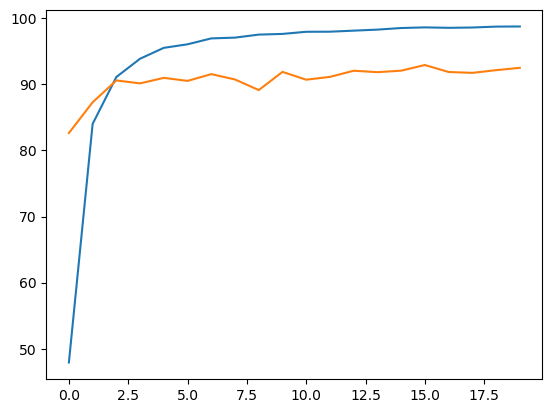

In [237]:
# Accuracy Analysis
plt.plot(train_accuracy)
plt.plot(val_accuracy)
plt.show()

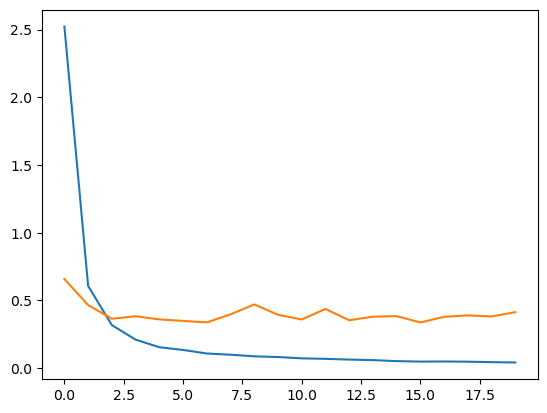

In [236]:
# Loss Analysis
plt.plot(train_loss)
plt.plot(val_loss)
plt.show()